# Import Libraries

In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from collections import Counter
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_confusion_matrix
from scikitplot.plotters import plot_precision_recall_curve, plot_roc_curve

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load Data

In [6]:
df = pd.read_excel("/mnt/hdd/Datasets/Date_Fruit_Datasets.xlsx")
df.head()

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,...,KurtosisRR,KurtosisRG,KurtosisRB,EntropyRR,EntropyRG,EntropyRB,ALLdaub4RR,ALLdaub4RG,ALLdaub4RB,Class
0,422163,2378.908,837.8484,645.6693,0.6373,733.1539,0.9947,424428,0.7831,1.2976,...,3.2370,2.9574,4.2287,-59191263232,-50714214400,-39922372608,58.7255,54.9554,47.8400,BERHI
1,338136,2085.144,723.8198,595.2073,0.5690,656.1464,0.9974,339014,0.7795,1.2161,...,2.6228,2.6350,3.1704,-34233065472,-37462601728,-31477794816,50.0259,52.8168,47.8315,BERHI
2,526843,2647.394,940.7379,715.3638,0.6494,819.0222,0.9962,528876,0.7657,1.3150,...,3.7516,3.8611,4.7192,-93948354560,-74738221056,-60311207936,65.4772,59.2860,51.9378,BERHI
3,416063,2351.210,827.9804,645.2988,0.6266,727.8378,0.9948,418255,0.7759,1.2831,...,5.0401,8.6136,8.2618,-32074307584,-32060925952,-29575010304,43.3900,44.1259,41.1882,BERHI
4,347562,2160.354,763.9877,582.8359,0.6465,665.2291,0.9908,350797,0.7569,1.3108,...,2.7016,2.9761,4.4146,-39980974080,-35980042240,-25593278464,52.7743,50.9080,42.6666,BERHI


In [7]:
df.shape

(898, 35)

In [14]:
total_null = df.isnull().sum().sum()
total_duplicated = df.duplicated().sum()

print("Number of null values:", total_null)
print("Number of duplicated values:", total_duplicated)

Number of null values: 0
Number of duplicated values: 0


# EDA

In [16]:
numerical_columns =  [col for col in df.columns if df[col].dtype != "object"]
categorical_columns = [col for col in df.columns if df[col].dtype == "object"]

print("Total Numerical Columns:", len(numerical_columns))
print("Total Categorical Columns:", len(categorical_columns))

Total Numerical Columns: 34
Total Categorical Columns: 1


# Target Value Distribution

In [25]:
def plot_count(df, col, title):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    plt.subplots_adjust(wspace=0.2)

    values = df[col].value_counts()
    N = len(values)

    outer_pie = values
    inner_pie = values / N

    ax[0].pie(
        outer_pie,
        labels=values.index.tolist(),
        startangle=90,
        frame=False,
        radius=1.3,
        explode=([0.05] * (N-1) + [0.3]),
        wedgeprops={"linewidth": 1, "edgecolor": "white"},
        textprops={"fontsize": 12, "weight": "bold"}
    )

    ax[0].pie(
        inner_pie,
        radius=1,
        startangle=90,
        autopct="%1.f%%",
        explode=([0.1] * (N-1) + [0.3]),
        pctdistance=0.8,
        textprops={"size": 13, "weight": "bold", "color": "white"}
    )

    center_circle = plt.Circle((0, 0), 0.7, color="black", fc="white", linewidth=0)
    ax[0].add_artist(center_circle)

    sns.barplot(x=values, y=values.index.tolist(), orient="horizontal")

    for i, v in enumerate(values):
        ax[1].text(v, i+0.1, str(v), color="black", fontweight="bold", fontsize=13)

    plt.setp(ax[1].get_yticklabels(), fontweight="bold")
    plt.setp(ax[1].get_xticklabels(), fontweight="bold")
    ax[1].set_xlabel(col, fontweight="bold", color="black")
    ax[1].set_ylabel("count", fontweight="bold", color="black")

    fig.suptitle(f"{title}", fontsize=18, fontweight="bold")
    plt.tight_layout()
    plt.show()

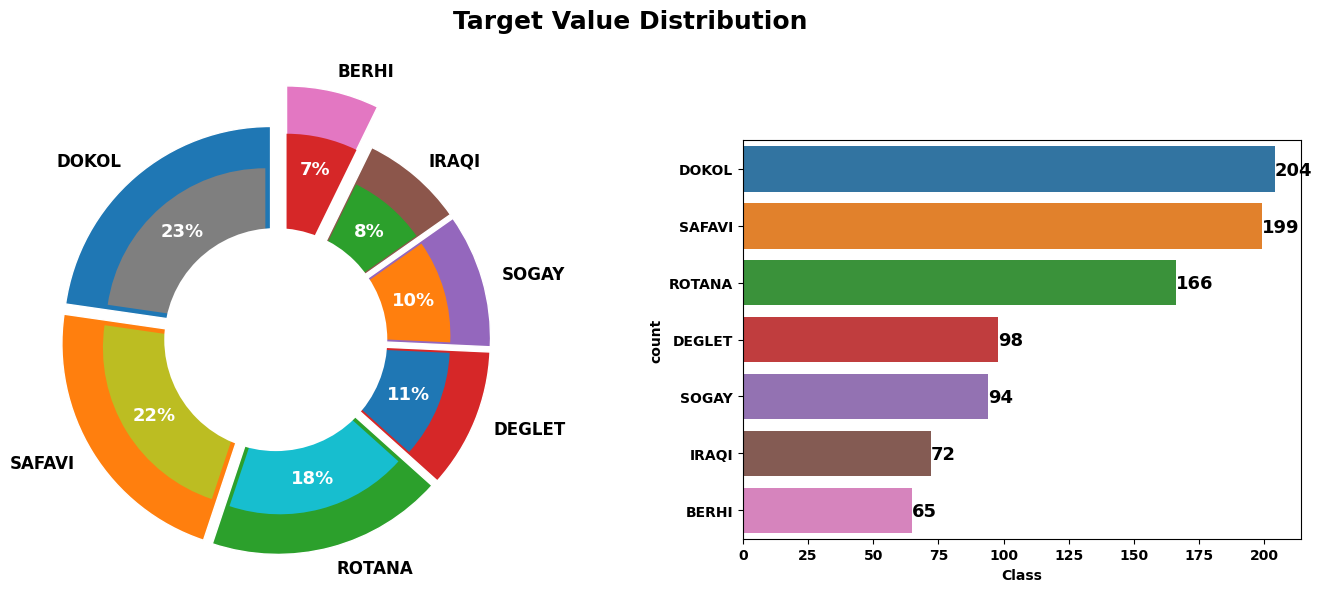

In [26]:
plot_count(df, "Class", "Target Value Distribution")

# Numerical Columns

In [46]:
def plot_num(df, columns, label):
    for i, column in enumerate(columns):
        plt.subplot(int(len(columns) / 2), 2, i+1)
        sns.histplot(x=column, hue=label, data=df, bins=30, kde=True)
        plt.axvline(df[column].mean(), color="r", linestyle="--", label="Mean")
        plt.axvline(df[column].median(), color="g", linestyle="-", label="Median")
        plt.grid()
        plt.title(f"{column} Distribution")
        plt.ylim(0, 100)
        plt.tight_layout()

    plt.show()

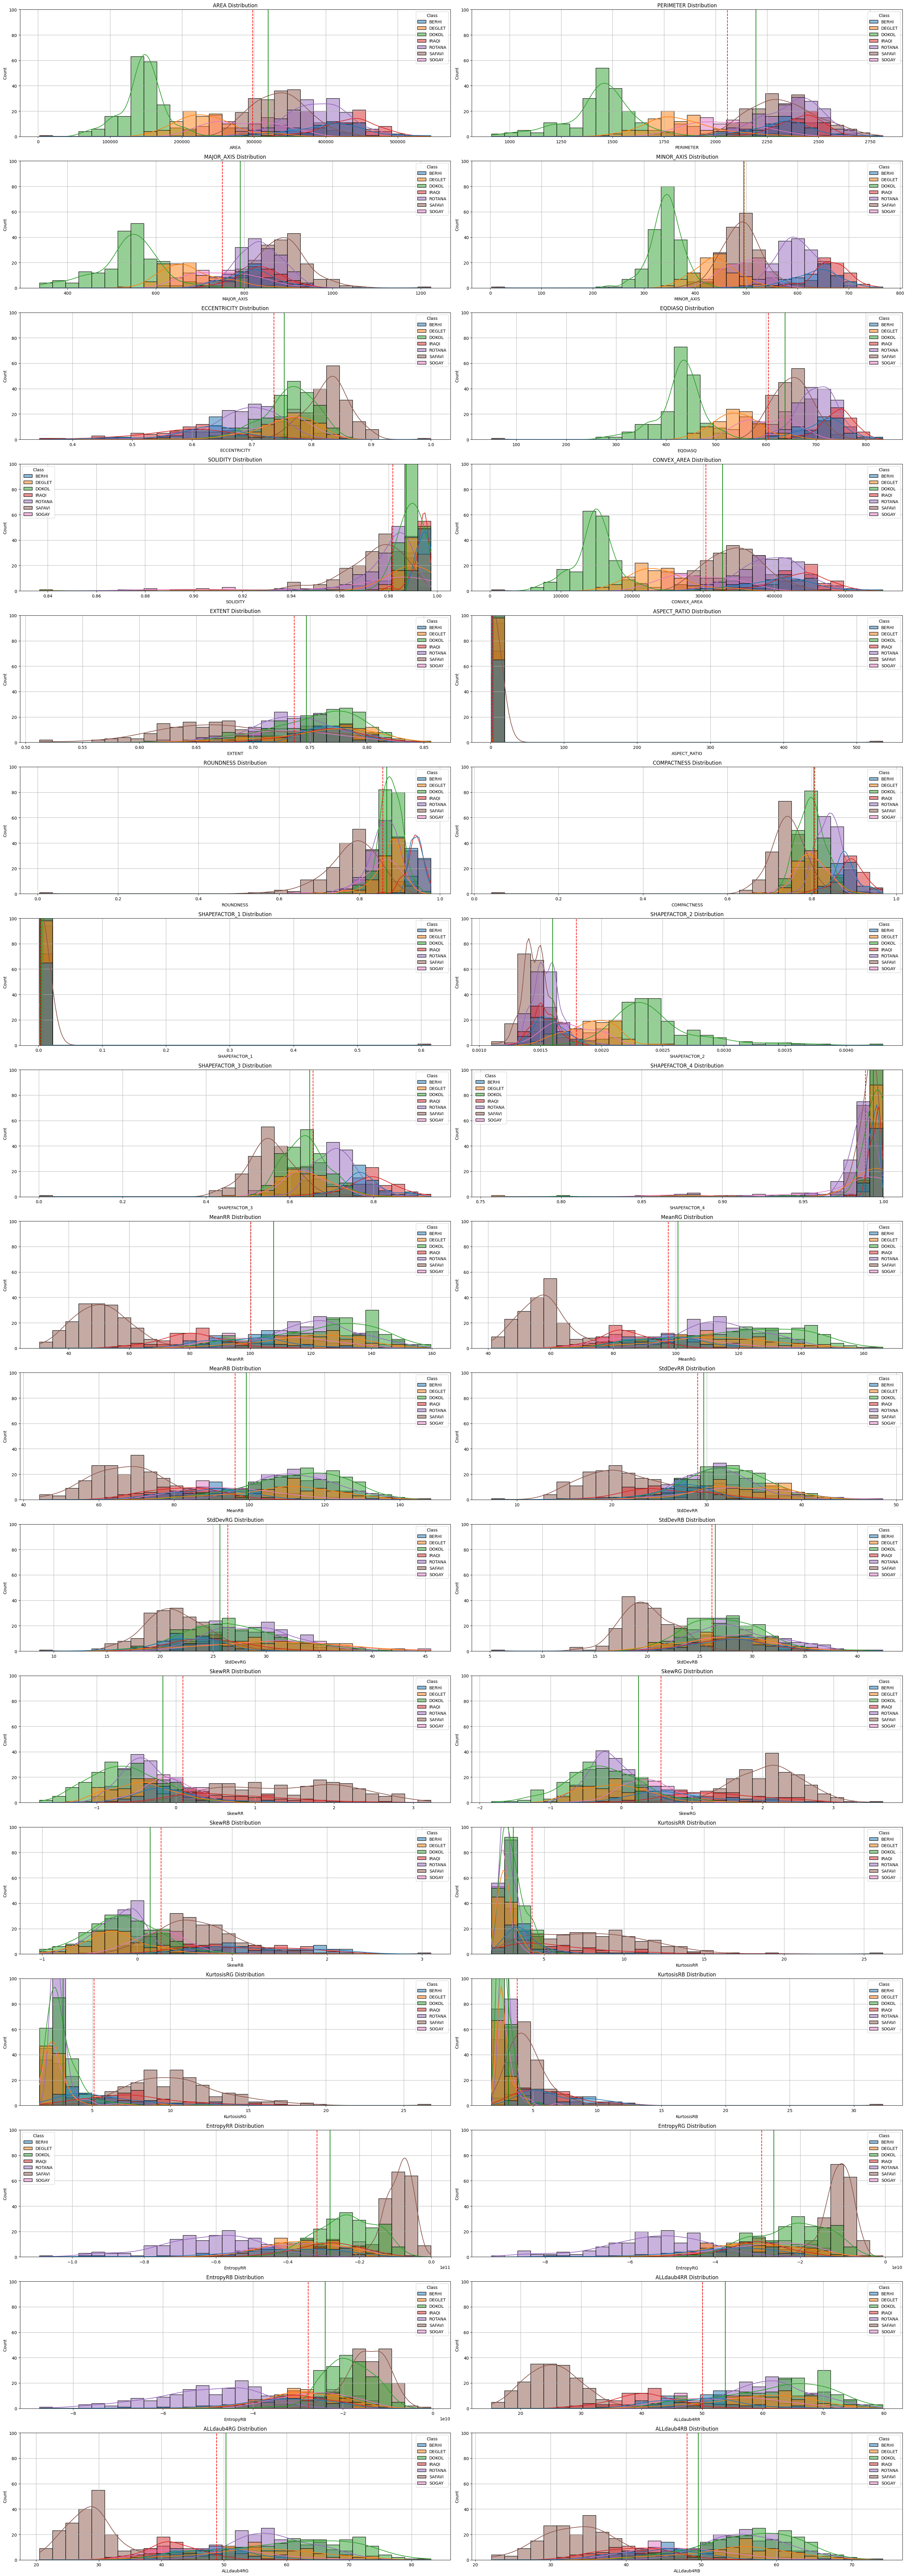

In [47]:
plt.figure(figsize=(30, len(numerical_columns) * 2.5))
plot_num(df, numerical_columns, "Class")

# Outlier Detection using Tukey's IQR 

In [49]:
def IQR_method(df, n, columns):
    outlier_list = []
    
    for column in columns:
        Q1 = np.percentile(df[column], 25)
        Q3 = np.percentile(df[column],75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        outlier_list.extend(outlier_list_column)
        
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )

    df1 = df[df[column] < Q1 - outlier_step]
    df2 = df[df[column] > Q3 + outlier_step]
    print('Total number of outliers is:', df1.shape[0]+df2.shape[0])
    return multiple_outliers

In [51]:
iqr_outliers = IQR_method(df, 1, numerical_columns)

Total number of outliers is: 0


# Multicollinearity

In [55]:
df_corr = df.copy()
le = LabelEncoder()
le.fit(df_corr["Class"])

df_corr["Class"] = le.transform(df_corr["Class"])

In [61]:
joblib.dump(le, "models/label-encoder.joblib")

['models/label-encoder.joblib']

In [57]:
def plot_correlation_table(df):
    corr = df.corr()
    fig, axes = plt.subplots(figsize=(11, 11))
    mask = np.triu(np.ones_like(corr))
    sns.heatmap(corr, mask=mask, linewidth=0.6, annot=True, robust=True, center=0, square=True)
    plt.title("Correlation Table")
    plt.show()

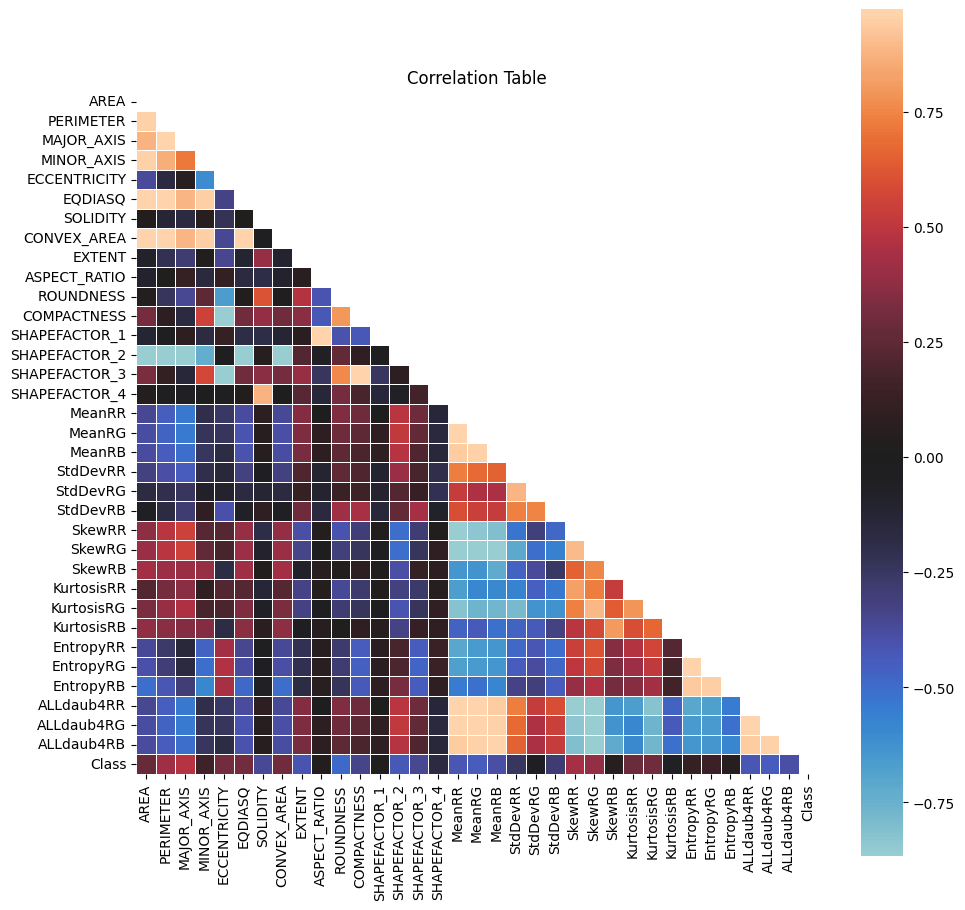

In [58]:
plot_correlation_table(df_corr)

In [67]:
def plot_clustermap(df):
    corr = df.corr()
    plt.figure(figsize=(11, 11))
    sns.clustermap(corr, vmin=-1, vmax=1, annot=True)
    plt.title("Cluster Map")
    plt.show()

<Figure size 1100x1100 with 0 Axes>

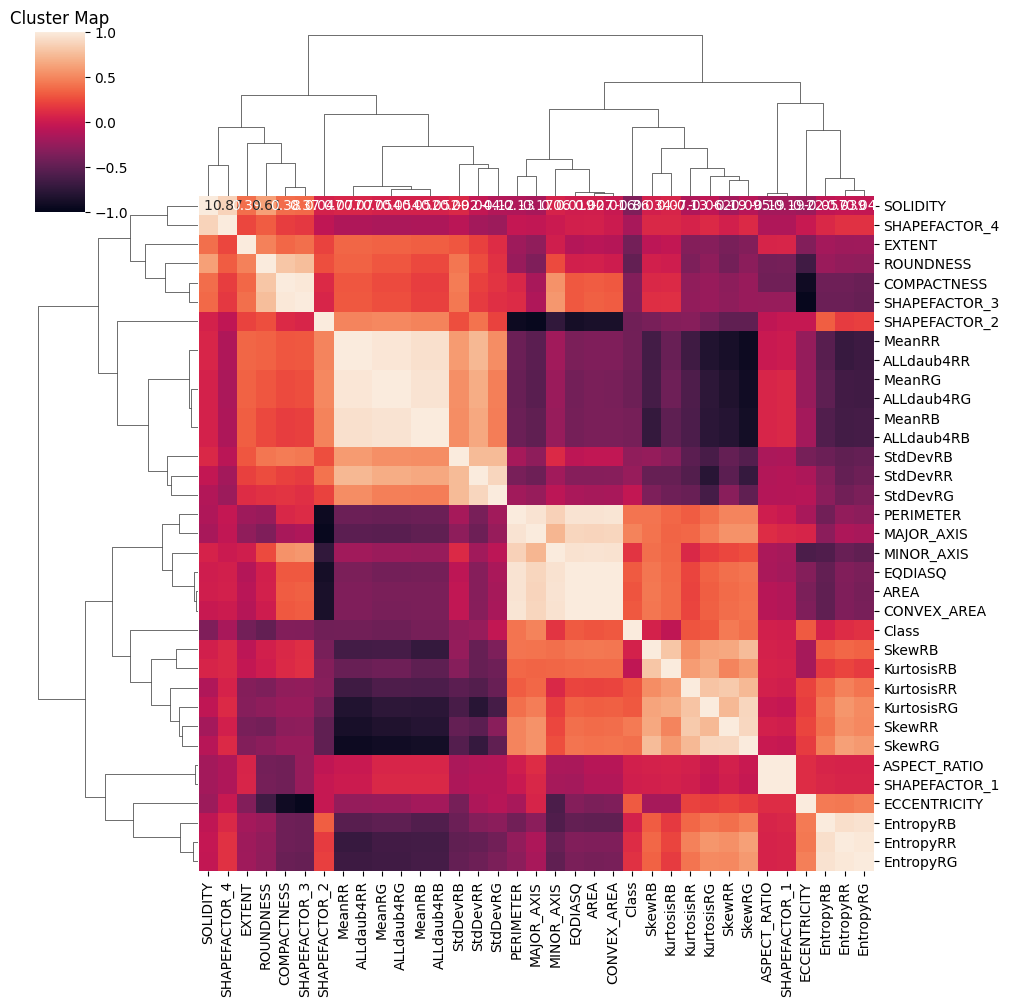

In [68]:
plot_clustermap(df_corr)

In [70]:
def plot_correlated_features(df, target):
    d = df_corr.corr()[target][:-1].abs().sort_values().plot(kind="bar", title=f"Highly Correlated Features with '{target}'")

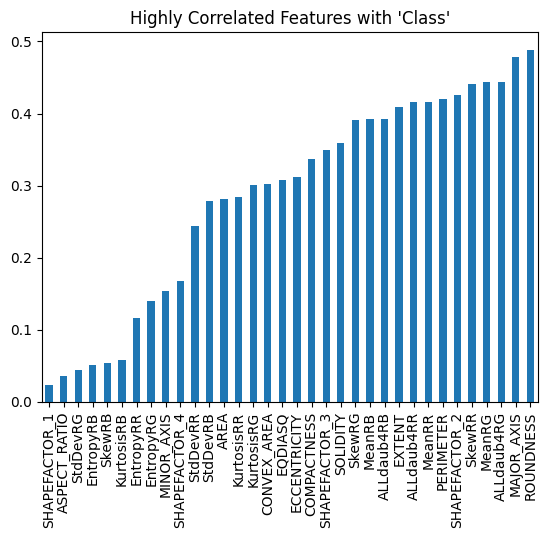

In [73]:
plot_correlated_features(df_corr, "Class")

# Variance Inflation Factor (VIF)

In [108]:
vif_data = pd.DataFrame()
vif_columns = ['AREA', 'PERIMETER', 'MAJOR_AXIS', 'MINOR_AXIS',
 'ECCENTRICITY', 'EQDIASQ', 'SOLIDITY', 'CONVEX_AREA', 'EXTENT',
 'ASPECT_RATIO', 'ROUNDNESS', 'COMPACTNESS', 'SHAPEFACTOR_1', 'SHAPEFACTOR_2', 'SHAPEFACTOR_3',
 'SHAPEFACTOR_4', 'MeanRR', 'MeanRG', 'MeanRB', 'StdDevRR', 'StdDevRG', 'StdDevRB',
 'SkewRR', 'SkewRG', 'SkewRB', 'KurtosisRR', 'KurtosisRG', 'KurtosisRB', 'EntropyRR', 'EntropyRG',
 'EntropyRB', 'ALLdaub4RR', 'ALLdaub4RG', 'ALLdaub4RB']
vif_data["Feature"] = vif_columns
vif_data["VIF"] = [variance_inflation_factor(df[vif_columns].values, i) for i in range(len(vif_columns))]
print(vif_data)

          Feature           VIF
0            AREA  1.847762e+04
1       PERIMETER  2.477200e+03
2      MAJOR_AXIS  2.368605e+03
3      MINOR_AXIS  4.667469e+03
4    ECCENTRICITY  2.670084e+02
5         EQDIASQ  1.773301e+04
6        SOLIDITY  8.294566e+01
7     CONVEX_AREA  1.909495e+04
8          EXTENT  1.705131e+00
9    ASPECT_RATIO  2.002127e+05
10      ROUNDNESS  1.825911e+02
11    COMPACTNESS  3.728417e+03
12  SHAPEFACTOR_1  2.006322e+05
13  SHAPEFACTOR_2  1.182030e+02
14  SHAPEFACTOR_3  4.382846e+03
15  SHAPEFACTOR_4  5.282928e+01
16         MeanRR  9.111638e+07
17         MeanRG  1.980503e+08
18         MeanRB  1.337241e+08
19       StdDevRR  1.275997e+01
20       StdDevRG  1.031804e+01
21       StdDevRB  5.157332e+00
22         SkewRR  2.998942e+01
23         SkewRG  4.268525e+01
24         SkewRB  1.243629e+01
25     KurtosisRR  1.119586e+01
26     KurtosisRG  1.996161e+01
27     KurtosisRB  6.549345e+00
28      EntropyRR  2.658062e+02
29      EntropyRG  3.256201e+02
30      

# Imbalance Check

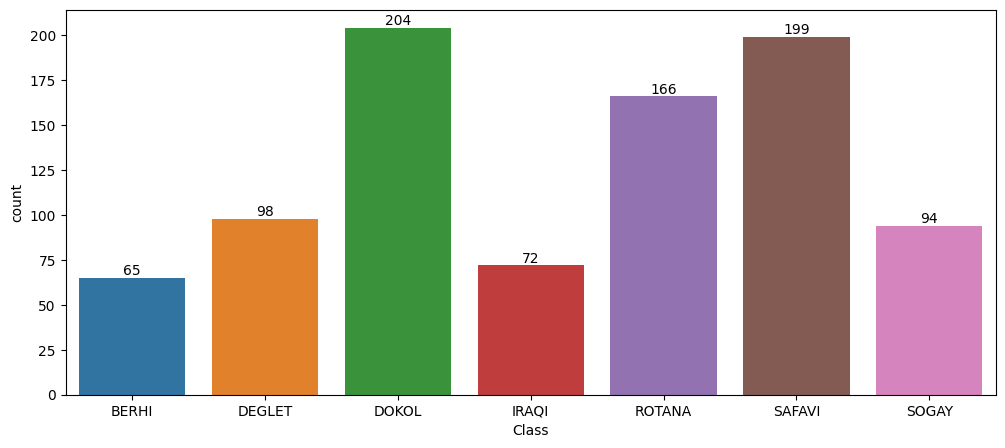

In [81]:
plt.figure(figsize=(12, 5))
ax = sns.countplot(data=df, x="Class")
for container in ax.containers:
    ax.bar_label(container)

plt.show()

In [88]:
le = joblib.load("models/label-encoder.joblib")
df["Class"] = le.transform(df["Class"])

In [94]:
le.classes_

array(['BERHI', 'DEGLET', 'DOKOL', 'IRAQI', 'ROTANA', 'SAFAVI', 'SOGAY'],
      dtype=object)

In [114]:
df = df.sample(frac=1).reset_index(drop=True)

In [115]:
X = df.drop("Class", axis=1)
y = df["Class"]

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [117]:
print("Before SMOTE:", Counter(y_train))

Before SMOTE: Counter({5: 163, 2: 158, 4: 135, 1: 82, 6: 69, 3: 60, 0: 51})


In [118]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [119]:
print("After SMOTE:", Counter(y_train_resampled))

After SMOTE: Counter({1: 163, 4: 163, 2: 163, 6: 163, 5: 163, 3: 163, 0: 163})


# Feature Scaling

In [120]:
mms = MinMaxScaler()
X_train_scaled = mms.fit_transform(X_train_resampled)
X_test_scaled = mms.transform(X_test)

# Model Training

# Random Forest

In [121]:
kf = StratifiedKFold(n_splits=5, shuffle=False)
rf = RandomForestClassifier()
rf.fit(X_train_scaled, y_train_resampled)

RandomForestClassifier()

In [170]:
joblib.dump(rf, "models/rf.joblib")

['models/rf.joblib']

In [123]:
rf_score = cross_val_score(rf, X_train_scaled, y_train_resampled, cv=kf, scoring="accuracy")
print("Random Forest Cross-Validation Accuracy Scores:", rf_score)
print("Average Accuracy Score:", rf_score.mean())

Random Forest Cross-Validation Accuracy Scores: [0.92576419 0.92982456 0.95614035 0.95614035 0.97368421]
Average Accuracy Score: 0.9483107331647898


In [128]:
rf_pred_train = rf.predict(X_train_scaled)
rf_pred_test = rf.predict(X_test_scaled)
rf_test_proba = rf.predict_proba(X_test_scaled)

rf_train_score = accuracy_score(rf_pred_train, y_train_resampled)
rf_test_score = accuracy_score(rf_pred_test, y_test)
print(f"Random Forest Train Score: {rf_train_score: .2f}")
print(f"Random Forest Test Score: {rf_test_score: .2f}")

Random Forest Train Score:  1.00
Random Forest Test Score:  0.90


In [135]:
rf_precision_score = precision_score(y_test, rf_pred_test, average="weighted")
rf_f1_score = f1_score(y_test, rf_pred_test, average="weighted")
rf_recall_score = recall_score(y_test, rf_pred_test, average="weighted")
rf_accuracy_score = recall_score(y_test, rf_pred_test, average="weighted")

print(f"Random Forest Precision Score: {rf_precision_score: .2f}")
print(f"Random Forest F1 Score: {rf_f1_score: .2f}")
print(f"Random Forest Recall Score: {rf_recall_score: .2f}")
print(f"Random Forest Accuracy Score: {rf_accuracy_score: .2f}")

Random Forest Precision Score:  0.92
Random Forest F1 Score:  0.90
Random Forest Recall Score:  0.90
Random Forest Accuracy Score:  0.90


In [138]:
print(classification_report(y_test, rf_pred_test, target_names=le.classes_))

              precision    recall  f1-score   support

       BERHI       1.00      0.64      0.78        14
      DEGLET       0.61      0.88      0.72        16
       DOKOL       0.98      0.87      0.92        46
       IRAQI       0.71      1.00      0.83        12
      ROTANA       1.00      1.00      1.00        31
      SAFAVI       0.97      0.97      0.97        36
       SOGAY       0.91      0.84      0.87        25

    accuracy                           0.90       180
   macro avg       0.88      0.89      0.87       180
weighted avg       0.92      0.90      0.90       180



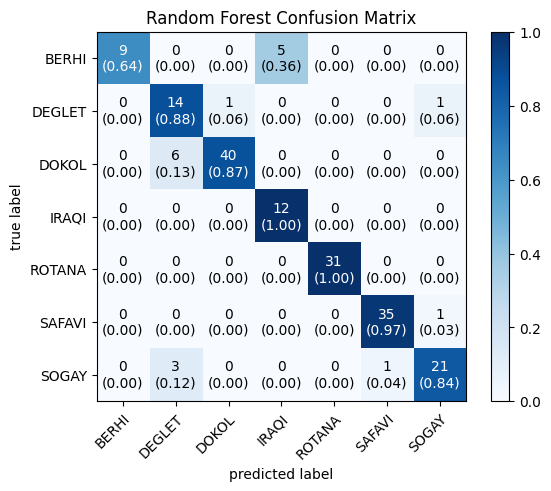

In [140]:
rf_cm = confusion_matrix(y_test, rf_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=rf_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=le.classes_)
plt.title("Random Forest Confusion Matrix")
plt.show()

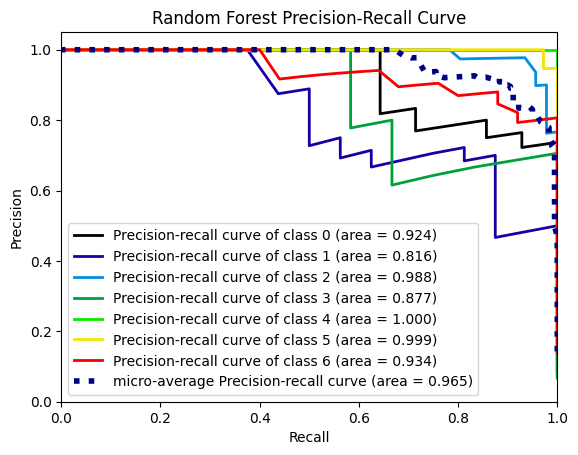

In [141]:
plot_precision_recall_curve(y_test, rf_test_proba, title="Random Forest Precision-Recall Curve")
plt.show()

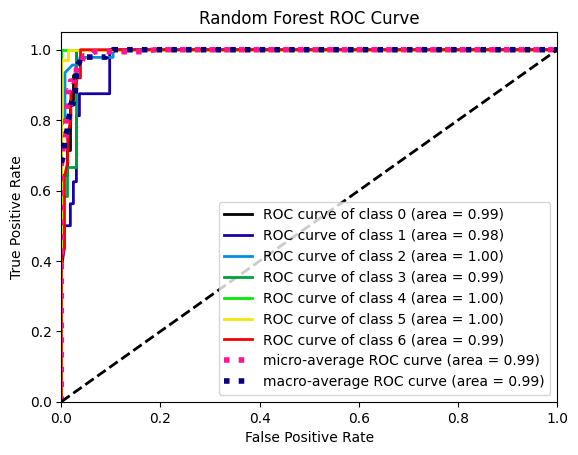

In [146]:
plot_roc_curve(y_test, rf_test_proba, title="Random Forest ROC Curve")
plt.show()

# Random Forest Hyper Parameter Tuning

In [182]:
rf_params = {
    "n_estimators": [100, 150, 200, 250, 500],
    "max_depth": [2, 3, 5, 8, 10],
    "min_samples_split": [2, 3, 4, 5, 6, 7],
    "min_samples_leaf": [1, 2, 3, 5]
}

grid_rf = GridSearchCV(RandomForestClassifier(), param_grid=rf_params, cv=kf, scoring="accuracy").fit(X_train_scaled, y_train_resampled)

In [183]:
print("Best parameters:", grid_rf.best_params_)
print("Best score:", grid_rf.best_score_)

Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best score: 0.9483107331647898


In [184]:
rf_tuned = RandomForestClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=500)
rf_tuned.fit(X_train_scaled, y_train_resampled)

RandomForestClassifier(max_depth=10, n_estimators=500)

In [185]:
rf_tuned_score = cross_val_score(rf_tuned, X_train_scaled, y_train_resampled, cv=kf, scoring="accuracy")
print("Random Forest (Tuned) Cross-Validation Accuracy Scores:", rf_tuned_score)
print("Average Accuracy Score:", rf_tuned_score.mean())

Random Forest (Tuned) Cross-Validation Accuracy Scores: [0.92139738 0.91666667 0.96052632 0.96052632 0.97807018]
Average Accuracy Score: 0.9474373707193748


In [186]:
rf_tuned_pred_train = rf_tuned.predict(X_train_scaled)
rf_tuned_pred_test = rf_tuned.predict(X_test_scaled)
rf_tuned_test_proba = rf_tuned.predict_proba(X_test_scaled)

rf_tuned_train_score = accuracy_score(rf_tuned_pred_train, y_train_resampled)
rf_tuned_test_score = accuracy_score(rf_tuned_pred_test, y_test)
print(f"Random Forest (Tuned) Train Score: {rf_tuned_train_score: .2f}")
print(f"Random Forest (Tuned) Test Score: {rf_tuned_test_score: .2f}")

Random Forest (Tuned) Train Score:  1.00
Random Forest (Tuned) Test Score:  0.91


In [187]:
rf_tuned_precision_score = precision_score(y_test, rf_tuned_pred_test, average="weighted")
rf_tuned_f1_score = f1_score(y_test, rf_tuned_pred_test, average="weighted")
rf_tuned_recall_score = recall_score(y_test, rf_tuned_pred_test, average="weighted")
rf_tuned_accuracy_score = recall_score(y_test, rf_tuned_pred_test, average="weighted")

print(f"Random Forest (Tuned) Precision Score: {rf_tuned_precision_score: .2f}")
print(f"Random Forest (Tuned) F1 Score: {rf_tuned_f1_score: .2f}")
print(f"Random Forest (Tuned) Recall Score: {rf_tuned_recall_score: .2f}")
print(f"Random Forest (Tuned) Accuracy Score: {rf_tuned_accuracy_score: .2f}")

Random Forest (Tuned) Precision Score:  0.92
Random Forest (Tuned) F1 Score:  0.91
Random Forest (Tuned) Recall Score:  0.91
Random Forest (Tuned) Accuracy Score:  0.91


In [188]:
print(classification_report(y_test, rf_tuned_pred_test, target_names=le.classes_))

              precision    recall  f1-score   support

       BERHI       1.00      0.64      0.78        14
      DEGLET       0.64      0.88      0.74        16
       DOKOL       0.98      0.87      0.92        46
       IRAQI       0.71      1.00      0.83        12
      ROTANA       1.00      1.00      1.00        31
      SAFAVI       0.97      0.97      0.97        36
       SOGAY       0.92      0.88      0.90        25

    accuracy                           0.91       180
   macro avg       0.89      0.89      0.88       180
weighted avg       0.92      0.91      0.91       180



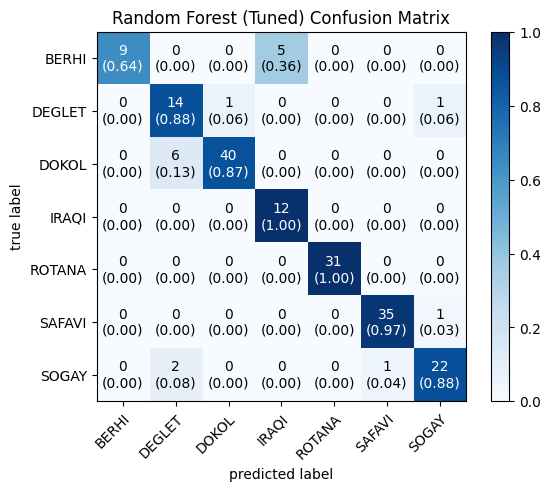

In [189]:
rf_tuned_cm = confusion_matrix(y_test, rf_tuned_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=rf_tuned_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=le.classes_)
plt.title("Random Forest (Tuned) Confusion Matrix")
plt.show()

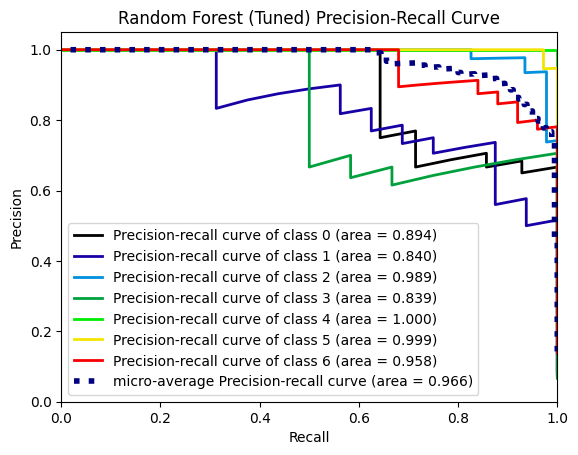

In [190]:
plot_precision_recall_curve(y_test, rf_tuned_test_proba, title="Random Forest (Tuned) Precision-Recall Curve")
plt.show()

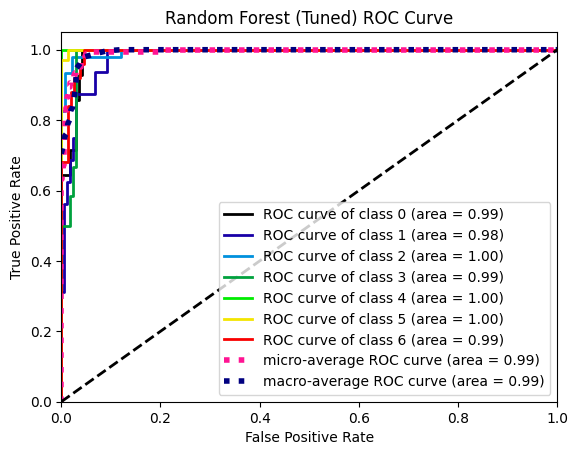

In [191]:
plot_roc_curve(y_test, rf_tuned_test_proba, title="Random Forest (Tuned) ROC Curve")
plt.show()